## Inverse Cooking: Recipe Generation from Food Images

In [63]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output, get_ingrs
from PIL import Image, ImageFile
import time

Set ```data_dir``` to the path including vocabularies and model checkpoint

In [64]:
data_dir = '../data'

In [65]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

In [66]:
# code below was used to save vocab files so that they can be loaded without Vocabulary class
#ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_ingrs.pkl'), 'rb'))
#ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
#vocab = pickle.load(open(os.path.join(data_dir, 'final_recipe1m_vocab_toks.pkl'), 'rb')).idx2word
#pickle.dump(ingrs_vocab, open('../demo/ingr_vocab.pkl', 'wb'))
#pickle.dump(vocab, open('../demo/instr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab.pkl'), 'rb'))
vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab.pkl'), 'rb'))

ingr_vocab_size = len(ingrs_vocab)
instrs_vocab_size = len(vocab)
output_dim = instrs_vocab_size

In [67]:
print (instrs_vocab_size, ingr_vocab_size)

23231 1488


In [68]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
args.maxseqlen = 15
args.ingrs_only=False
model = get_model(args, ingr_vocab_size, instrs_vocab_size)
# Load the trained model parameters
model_path = os.path.join(data_dir, 'modelbest.ckpt')
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()
model.ingrs_only = False
model.recipe_only = False
print ('loaded model')
print ("Elapsed time:", time.time() -t)


/Users/v.chitale/Desktop/Work/inversecooking/venv/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


loaded model
Elapsed time: 1.6715619564056396


In [69]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

In [70]:
greedy = [True]
beam = [-1]
temperature = 1.0
numgens = len(greedy)

Set ```use_urls = True``` to get recipes for images in ```demo_urls```. 

You can also set ```use_urls = False``` and get recipes for images in the path in ```data_dir/test_imgs```.

In [92]:
import requests
from io import BytesIO
import random
from collections import Counter
use_urls = False # set to true to load images from demo_urls instead of those in test_imgs folder
show_anyways = False #if True, it will show the recipe even if it's not valid
image_folder = os.path.join(data_dir, 'demo_imgs')

demo_urls = ['https://food.fnr.sndimg.com/content/dam/images/food/fullset/2013/12/9/0/FNK_Cheesecake_s4x3.jpg.rend.hgtvcom.826.620.suffix/1387411272847.jpeg',
            'https://www.196flavors.com/wp-content/uploads/2014/10/california-roll-3-FP.jpg']


In [96]:
import tensorflow as tf
import random, glob

img_dir = "gs://dh-reco-hackathon/images/tb_kw/"
_random_files = tf.io.gfile.glob(os.path.join(img_dir,'*'))
random.shuffle(_random_files)


for img in _random_files[:5]:
    tf.io.gfile.copy(
            img,
            image_folder,
            overwrite=True)

if not use_urls:
    demo_imgs = os.listdir(image_folder)
    random.shuffle(demo_imgs)

#demo_urls = ['https://storage.cloud.google.com/'+ x[5:] for x in _random_files[:5]]

PermissionDeniedError: ../data/demo_imgs; Operation not permitted

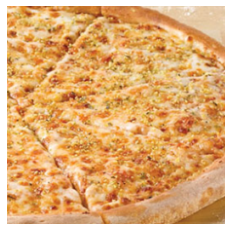

/Users/v.chitale/Desktop/Work/inversecooking/src/modules/multihead_attention.py:126: UserWarning: masked_fill_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:650.)
  attn_weights = attn_weights.float().masked_fill(



Ingredients:
cheese, bread, mayonnaise


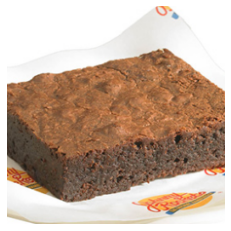


Ingredients:
sugar, egg, flour, butter, chocolate, vanilla


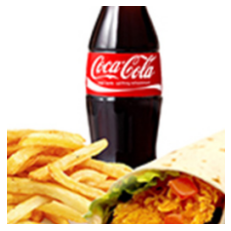


Ingredients:
tortilla, lettuce, tomato, cheese, salsa, pepper


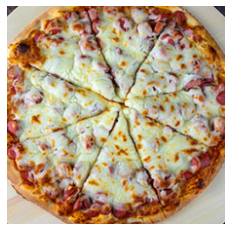


Ingredients:
cheese, pizza_sauce, pepperoni, oil, flour, salt, yeast, water, onion, pepper


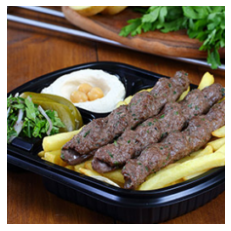


Ingredients:
pepper, oil, salt, clove, egg, parsley, onion, lamb, mustard, juice


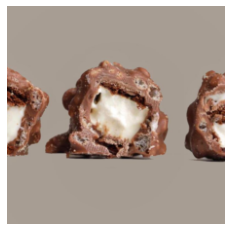


Ingredients:
sugar, butter, marshmallow, salt, egg, flour, extract, cocoa


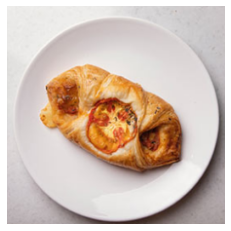


Ingredients:
cheese, oil, pepper, pizza_dough, salt, egg


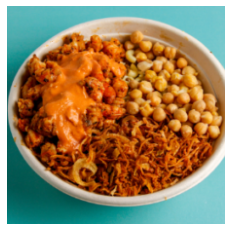


Ingredients:
onion, pepper, tomato, chili, beans, cumin, clove, beef, salt, paprika, oil


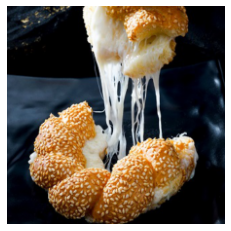


Ingredients:
seeds, flour, sugar, egg, salt, milk, cheese, baking_powder, oil


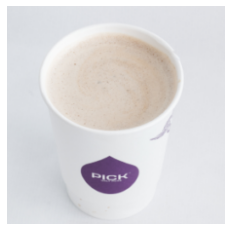


Ingredients:
milk, sugar, cocoa, extract, coffee


In [94]:
demo_files = demo_urls if use_urls else demo_imgs


for img_file in demo_files:
    
    if use_urls:
        response = requests.get(img_file, stream=True)
        image = Image.open(BytesIO(response.content))

    else:
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(256))
    transf_list.append(transforms.CenterCrop(224))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()
    
    num_valid = 1
    for i in range(numgens):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=greedy[i], 
                                   temperature=temperature, beam=beam[i], true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        recipe_ids = outputs['recipe_ids'].cpu().numpy()
            
        #outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
        
        outs = {'ingrs': get_ingrs(ingr_ids[0], ingrs_vocab)}
        
        print ('\nIngredients:')
        print (', '.join(outs['ingrs']))
        
        print ('='*20)
